In [3]:
# -*- coding: utf-8 -*- 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler,LabelBinarizer
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
import math
import xgboost as xgb
%matplotlib inline

#import sys  
#reload(sys)  
#sys.setdefaultencoding('utf-8')

# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
train=pd.read_csv('train.csv',sep='\t',encoding='cp1251',parse_dates=['regdt','OrgCreationDate'])
test=pd.read_csv('test.csv',sep='\t',encoding='cp1251',parse_dates=['regdt','OrgCreationDate'])
train.head()

,id,taxactionSystem,regdt,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,OrgCreationDate,documentsCount,cnt_users,is_prolong
0,101969,"УСН, Доходы 6%",1994-03-26,5.0,0.0,0.0,0.0,0,2014-04-12,2.0,0.0,1.0
1,108477,ОСНО,2012-12-05,1.0,0.0,0.0,0.0,0,2014-09-22,5.0,0.0,0.0
2,101476,"УСН, Доходы 6%",2009-11-15,1.0,3.0,3.0,2.0,0,2016-05-04,0.0,0.0,1.0
3,102579,"УСН, Доходы за вычетом расходов 15%",2015-08-09,1.0,0.0,0.0,0.0,0,2015-09-24,0.0,0.0,0.0
4,103110,"УСН, Доходы за вычетом расходов 15%",2015-03-29,0.0,0.0,0.0,0.0,0,2015-03-04,4.0,0.0,0.0


In [5]:
train.drop(axis=0,index=train[train['regdt']=='0001-01-01 00:00:00.0000000']['regdt'].index.values,inplace=True)
train[['regdt','OrgCreationDate']]=train[['regdt','OrgCreationDate']].apply(pd.to_datetime)
train.dropna(axis=0, how='any',inplace=True)

columns = train.select_dtypes(['floating']).columns
train[columns] = train[columns].astype('int64')

train['regdt_year']=pd.DatetimeIndex(train['regdt']).year
train['regdt_month']=pd.DatetimeIndex(train['regdt']).month
train['regdt_day']=pd.DatetimeIndex(train['regdt']).day

train['OrgCreationDate_year']=pd.DatetimeIndex(train['OrgCreationDate']).year
train['OrgCreationDate_month']=pd.DatetimeIndex(train['OrgCreationDate']).month
train['OrgCreationDate_day']=pd.DatetimeIndex(train['OrgCreationDate']).day

train.drop(axis=1,columns=['regdt','OrgCreationDate'],inplace=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7598 entries, 0 to 7625
Data columns (total 16 columns):
id                          7598 non-null int64
taxactionSystem             7598 non-null object
workerCount                 7598 non-null int64
fssdccount                  7598 non-null int64
pfrdcCount                  7598 non-null int64
fnsdcCount                  7598 non-null int64
hasCloudCryptCertificate    7598 non-null int64
documentsCount              7598 non-null int64
cnt_users                   7598 non-null int64
is_prolong                  7598 non-null int64
regdt_year                  7598 non-null int64
regdt_month                 7598 non-null int64
regdt_day                   7598 non-null int64
OrgCreationDate_year        7598 non-null int64
OrgCreationDate_month       7598 non-null int64
OrgCreationDate_day         7598 non-null int64
dtypes: int64(15), object(1)
memory usage: 1009.1+ KB


In [6]:
train.head()

,id,taxactionSystem,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,documentsCount,cnt_users,is_prolong,regdt_year,regdt_month,regdt_day,OrgCreationDate_year,OrgCreationDate_month,OrgCreationDate_day
0,101969,"УСН, Доходы 6%",5,0,0,0,0,2,0,1,1994,3,26,2014,4,12
1,108477,ОСНО,1,0,0,0,0,5,0,0,2012,12,5,2014,9,22
2,101476,"УСН, Доходы 6%",1,3,3,2,0,0,0,1,2009,11,15,2016,5,4
3,102579,"УСН, Доходы за вычетом расходов 15%",1,0,0,0,0,0,0,0,2015,8,9,2015,9,24
4,103110,"УСН, Доходы за вычетом расходов 15%",0,0,0,0,0,4,0,0,2015,3,29,2015,3,4


# Посмотрим на данные

Распределение целевой переменной: 	


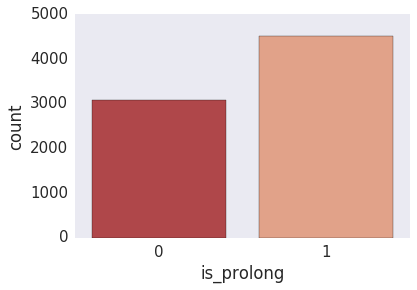

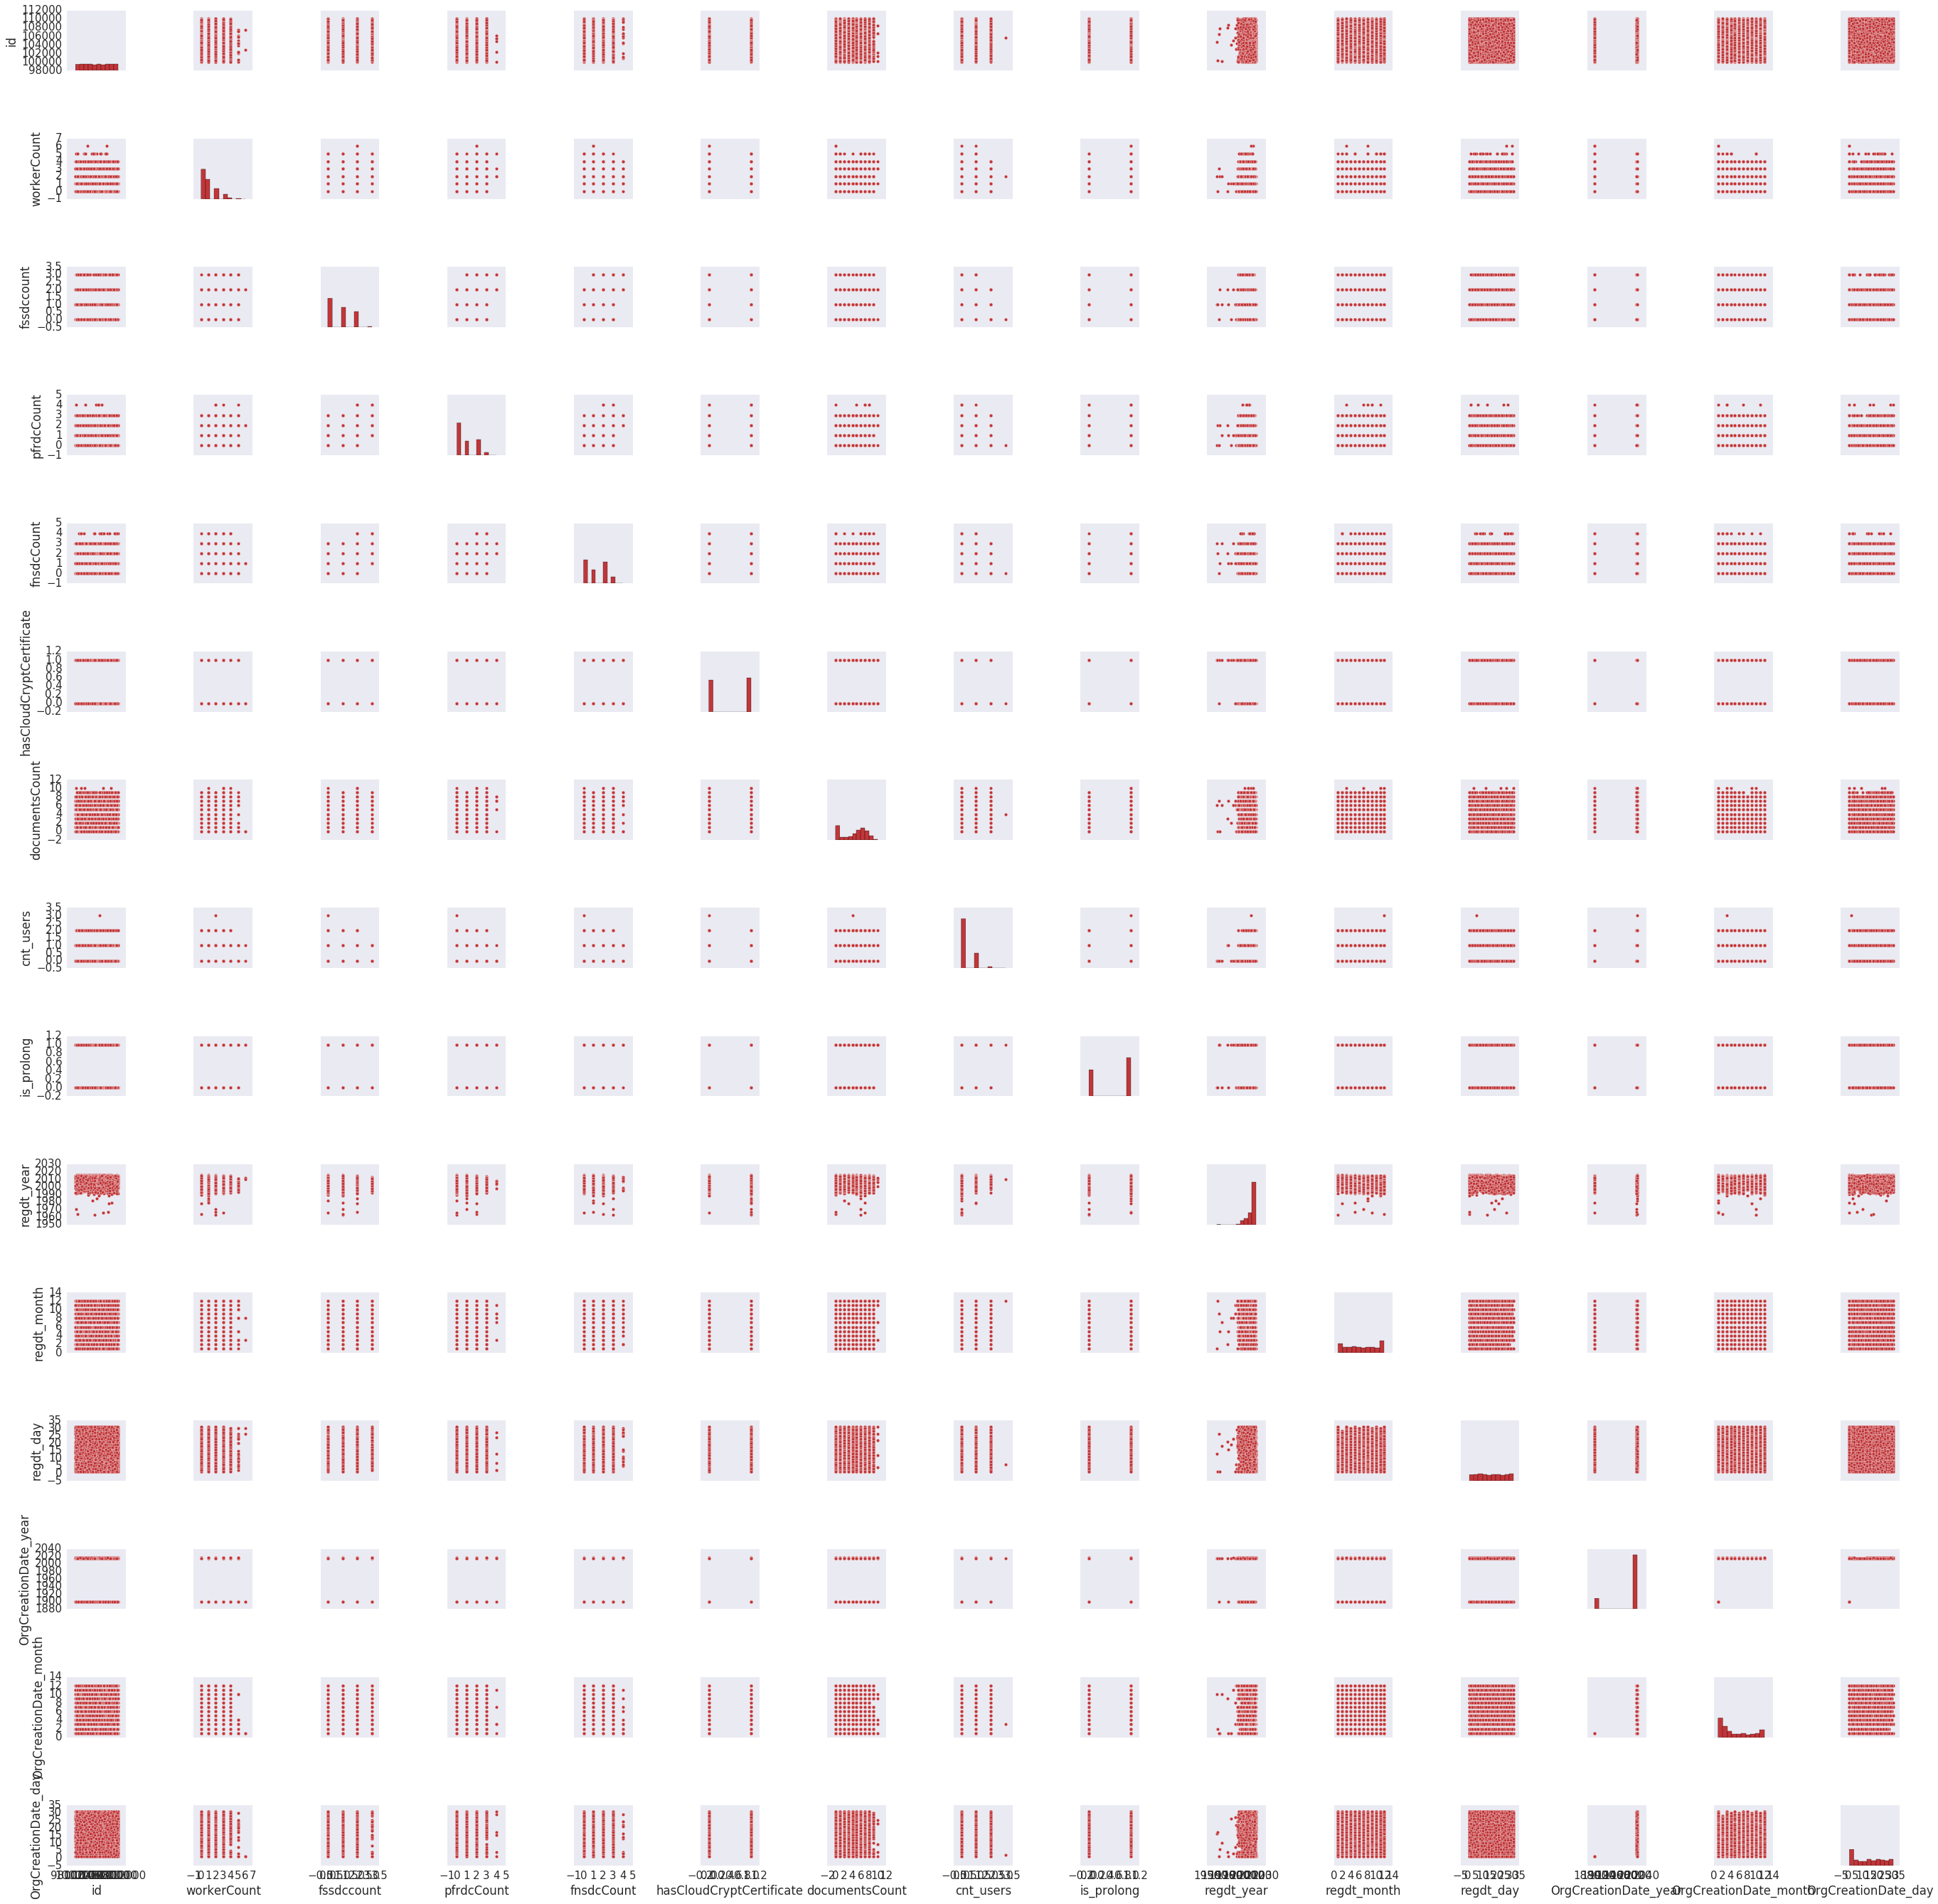

In [7]:
print 'Распределение целевой переменной: \t'
sns.countplot(train.is_prolong)

sns.pairplot(train)

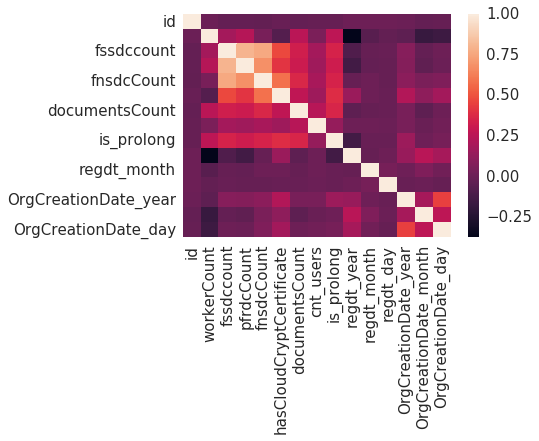

In [13]:
sns.heatmap(train.corr(method='spearman'));

## Label Encoding and OneHotEncoder

{0: u'\u0415\u041d\u0412\u0414', 1: u'\u041e\u0421\u041d\u041e', 2: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 3%', 3: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 3% +\u0415\u041d\u0412\u0414', 4: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 4%', 5: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 6%', 6: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 6% +\u0415\u041d\u0412\u0414', 7: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b \u0437\u0430 \u0432\u044b\u0447\u0435\u0442\u043e\u043c \u0440\u0430\u0441\u0445\u043e\u0434\u043e\u0432 10%', 8: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b \u0437\u0430 \u0432\u044b\u0447\u0435\u0442\u043e\u043c \u0440\u0430\u0441\u0445\u043e\u0434\u043e\u0432 10% +\u0415\u041d\u0412\u0414', 9: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b \u0437\u0430 \u0432\u044b\u0447\u0435\u0442\u043e\u043c \u0440\u0430\u0441\u0445\u043e\u0434\u043e\u0432 12%', 10:

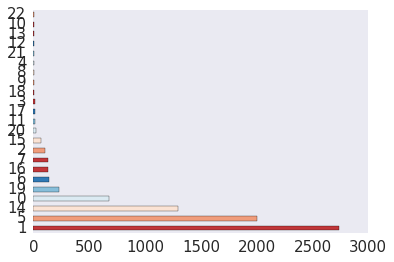

In [8]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(train['taxactionSystem']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [9]:
# integer encode
integer_encoded = label_encoder.fit_transform(train['taxactionSystem']).astype('int')
print integer_encoded[:5]
train['taxactionSystem']=integer_encoded
# binary encode Не зашло
#onehot_encoder = OneHotEncoder(sparse=False)
#integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
#onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded[:5])

# invert first example
#inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
#print(inverted)

[ 5  1  5 14 14]


In [10]:
#train=train.join(pd.DataFrame(onehot_encoded,columns=["taxactionSystem_"+str(i) for i in range(onehot_encoded.shape[1])]),how='outer')
#train.drop(columns='taxactionSystem',axis=1,inplace=True)
#train.dropna(axis=0, how='any',inplace=True)
#train[train.columns] = train[train.columns].astype('int64')
#train.info()

In [11]:
target=train.is_prolong
train.drop(axis=1,columns=['is_prolong','id'],inplace=True)

## Метрика

In [12]:
def getROC_AUC(method,test_X,test_y):
    precision, recall, thresholds = precision_recall_curve(test_y, method.predict_proba(test_X)[:,1])
    plt.title("precision-recall")
    plt.plot(recall,precision)

    fpr, tpr, thresholds = roc_curve(test_y, method.predict_proba(test_X)[:,1])
    plt.figure()
    plt.title("ROC-AUC")
    plt.plot(fpr,tpr)

## Логистическая регрессия

In [13]:
train_X,test_X,train_y,test_y=train_test_split(train,target,shuffle=True,random_state=17,test_size=0.2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished


({'lr__C': 1.0}, 0.75090490292859491)
0.767763157895
0.751332990258


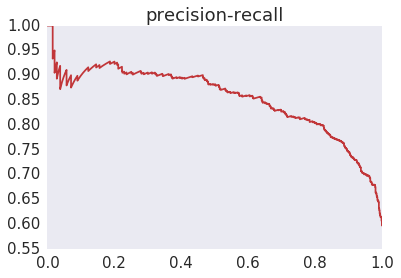

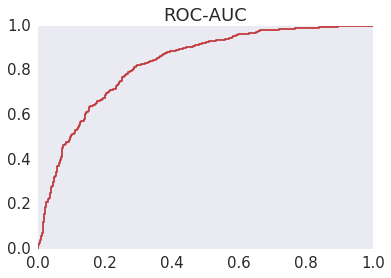

In [20]:
from sklearn.pipeline import Pipeline

lr=LogisticRegression(n_jobs=4)
lr_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(n_jobs=-1))])
lr_params = {'lr__C':np.logspace(-8, 1, 10)}
lr_grid = GridSearchCV(lr_pipe, lr_params,
                         cv=5, n_jobs=-1,
                        verbose=True,scoring='accuracy')
lr_grid.fit(train_X, train_y)
lr_pred=lr_grid.predict(test_X)
print (lr_grid.best_params_, lr_grid.best_score_)
print accuracy_score(test_y, lr_pred)
print roc_auc_score(test_y, lr_pred)
getROC_AUC(lr_grid,test_X,test_y)

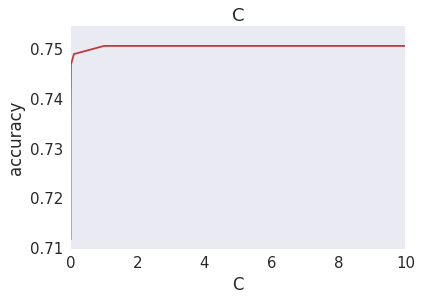

In [22]:
plt.title("C")
plt.plot(np.logspace(-8, 1, 10),lr_grid.cv_results_['mean_test_score'])
plt.ylabel('accuracy')
plt.xlabel('C')

## Случайный лес

In [57]:
rnd_forest=RandomForestClassifier(n_jobs=-1,random_state=42,oob_score=False)
forest_params = {'max_depth': [9,10,11]
                #,'max_features': [4, 7, 10, 14]
                #,'min_samples_leaf':[1, 5, 7, 10]
                ,'n_estimators':[75, 100, 125]
                }
forest_grid=GridSearchCV(rnd_forest,forest_params,verbose=True,n_jobs=-1)
forest_grid.fit(train_X,train_y)
print (forest_grid.best_params_)

pred_forest=forest_grid.predict(test_X)
print accuracy_score(test_y,pred_forest)
print roc_auc_score(test_y, pred_forest)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    2.8s finished


{'n_estimators': 125, 'max_depth': 10}
0.810526315789
0.790799150889


[{'max_depth': 9, 'n_estimators': 75},
 {'max_depth': 9, 'n_estimators': 100},
 {'max_depth': 9, 'n_estimators': 125},
 {'max_depth': 10, 'n_estimators': 75},
 {'max_depth': 10, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 125},
 {'max_depth': 11, 'n_estimators': 75},
 {'max_depth': 11, 'n_estimators': 100},
 {'max_depth': 11, 'n_estimators': 125}]

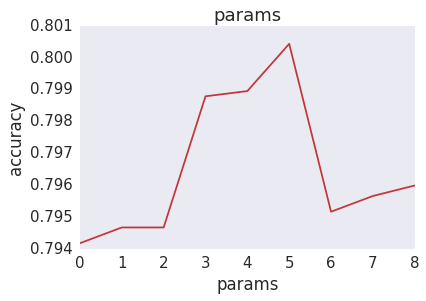

In [58]:
plt.title("params")
plt.plot(forest_grid.cv_results_['mean_test_score'])
plt.ylabel('accuracy')
plt.xlabel('params')

forest_grid.cv_results_['params']

0.810526315789
0.791278026746


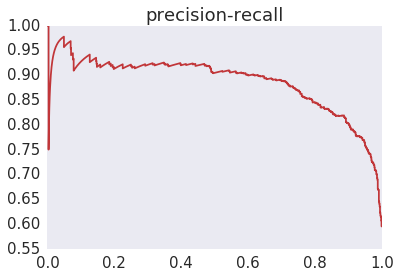

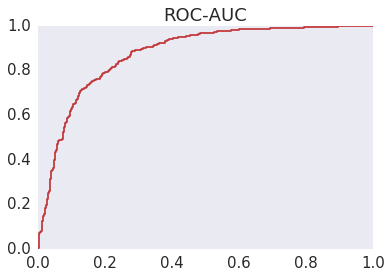

In [59]:
rnd_forest=RandomForestClassifier(n_jobs=-1,n_estimators=125,max_depth=10,max_features=int(math.sqrt(len(train_X.columns))),random_state=17)
rnd_forest.fit(train_X,train_y)
pred_forest=rnd_forest.predict(test_X)
print accuracy_score(test_y,pred_forest)
print roc_auc_score(test_y, pred_forest)
getROC_AUC(rnd_forest,test_X,test_y)

## Градиентрный бустинг

In [108]:
g_boost=GradientBoostingClassifier(random_state=42,learning_rate=0.6)
boost_params = {'max_depth': [3,4,5]
                #,'max_features': [4, 7, 10, len(train_X.columns)]
                ,'min_samples_leaf':[1,5,8]
                ,'n_estimators':[20,40]
                }
boost_grid=GridSearchCV(g_boost,boost_params,verbose=True,n_jobs=-1)
boost_grid.fit(train_X,train_y)
print (boost_grid.best_params_)

pred_boost=boost_grid.predict(test_X)
print (pred_boost[:10])
print (test_y[:10].values)
print accuracy_score(test_y,pred_boost)
print roc_auc_score(test_y, pred_boost)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'n_estimators': 40, 'max_depth': 3, 'min_samples_leaf': 1}
[1 1 1 1 1 0 0 1 1 1]
[1 1 1 1 0 0 0 1 0 1]
0.791447368421
0.776016539086


[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    1.1s finished


[{'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 20},
 {'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 40},
 {'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 20},
 {'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 40},
 {'max_depth': 3, 'min_samples_leaf': 8, 'n_estimators': 20},
 {'max_depth': 3, 'min_samples_leaf': 8, 'n_estimators': 40},
 {'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 20},
 {'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 40},
 {'max_depth': 4, 'min_samples_leaf': 5, 'n_estimators': 20},
 {'max_depth': 4, 'min_samples_leaf': 5, 'n_estimators': 40},
 {'max_depth': 4, 'min_samples_leaf': 8, 'n_estimators': 20},
 {'max_depth': 4, 'min_samples_leaf': 8, 'n_estimators': 40},
 {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 20},
 {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 40},
 {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 20},
 {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 40},
 {'max_d

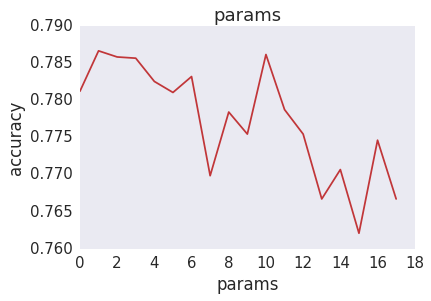

In [109]:
plt.title("params")
plt.plot(boost_grid.cv_results_['mean_test_score'])
plt.ylabel('accuracy')
plt.xlabel('params')

boost_grid.cv_results_['params']

0.802631578947
0.785045493206


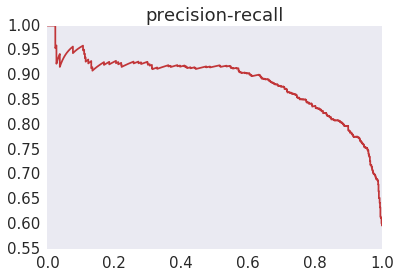

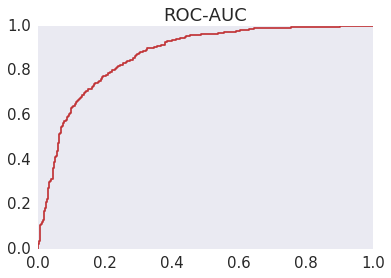

In [110]:
g_boost=GradientBoostingClassifier(random_state=42,n_estimators=70,max_depth=6,learning_rate=0.07)
g_boost.fit(train_X,train_y)
pred_boost=g_boost.predict(test_X)
print accuracy_score(test_y,pred_boost)
print roc_auc_score(test_y, pred_boost)
getROC_AUC(g_boost,test_X,test_y)

## xgboost

In [ ]:
x_boost=xgb.XGBClassifier()
X_boost_params = {'max_depth': [1,3,5,10]
                ,'n_estimators':[50, 75, 100]
                #,'learning_rate':np.arange(0.01,0.1,0.02)
                }
x_boost_grid=GridSearchCV(x_boost,X_boost_params,verbose=True,n_jobs=-1)
x_boost_grid.fit(train_X,train_y)
print (x_boost_grid.best_params_)

pred_x_boost=x_boost_grid.predict(test_X)
print accuracy_score(test_y,pred_x_boost)
print roc_auc_score(test_y, pred_x_boost)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


0.797368421053
0.777458527207


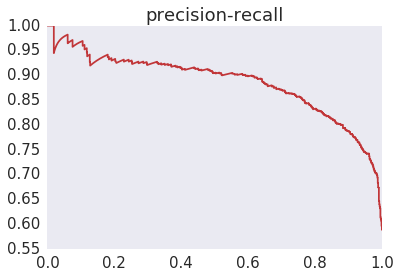

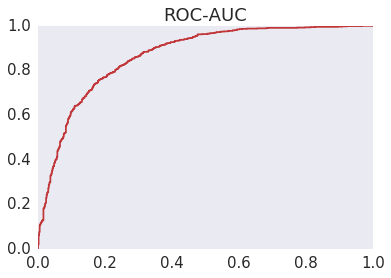

In [135]:
x_boost=xgb.XGBClassifier(n_estimators=70,learning_rate=0.07,max_depth=4)
x_boost.fit(train_X,train_y)
pred_x_boost=x_boost.predict(test_X)
print accuracy_score(test_y,pred_x_boost)
print roc_auc_score(test_y, pred_x_boost)
getROC_AUC(x_boost,test_X,test_y)

## Метод ближайших соседей

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.3s finished


({'knn__n_neighbors': 13}, 0.76340901612372492)
0.797368421053
0.779613468562


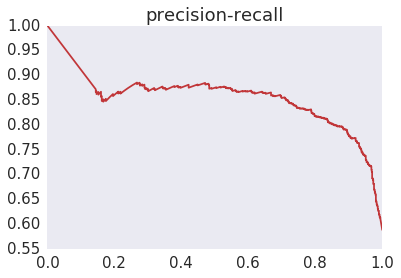

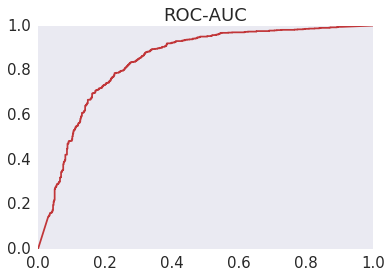

In [124]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1,weights='distance'))])
n_neighbors=range(5, 15)
knn_params = {'knn__n_neighbors': n_neighbors}
knn_grid = GridSearchCV(knn_pipe, knn_params,
                         cv=5, n_jobs=-1,
                        verbose=True)
knn_grid.fit(train_X, train_y)
print (knn_grid.best_params_, knn_grid.best_score_)
print accuracy_score(test_y, knn_grid.predict(test_X))
print roc_auc_score(test_y, knn_grid.predict(test_X))
getROC_AUC(knn_grid,test_X,test_y)

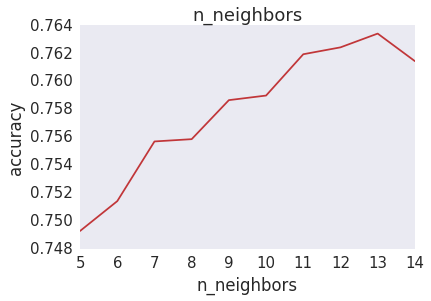

In [125]:
plt.title("n_neighbors")
plt.plot(n_neighbors,knn_grid.cv_results_['mean_test_score'])
plt.ylabel('accuracy')
plt.xlabel('n_neighbors')

## CatBoost

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(max_depth=9,iterations=100, learning_rate=1, loss_function='Logloss',random_state=17,logging_level='Silent')
params = {'depth':[3,1,2,6,4,5,7,8,9,10]
          #,'iterations':[250,100,500,1000],
          #'learning_rate':[0.03,0.1,0.2,0.3], 
          #'l2_leaf_reg':[3,1,5,10,100],
          #'border_count':[32,5,10,20,50,100,200]
         }
catboost_gscv=GridSearchCV(model,params,n_jobs=4)
#train the model
catboost_gscv.fit(train_X, train_y)
# make the prediction using the resulting model
preds_class = catboost_gscv.predict(test_X)
preds_proba = catboost_gscv.predict_proba(test_X)
print accuracy_score(test_y,preds_class)
print roc_auc_score(test_y, preds_class)
getROC_AUC(catboost_gscv,test_X,test_y)

## Удалим лишние признаки

Fitting 5 folds for each of 10 candidates, totalling 50 fits
({'lr__C': 0.10000000000000001}, 0.74547548535702535)
0.769078947368
0.751254368849


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


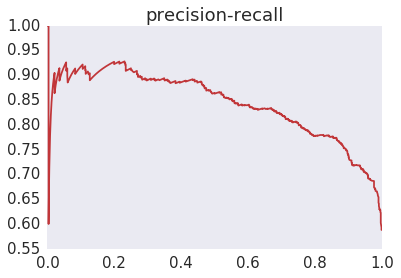

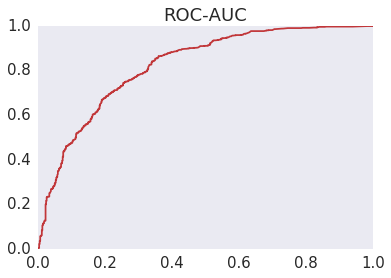

In [38]:
train_X2=train_X.drop(axis=1,columns=['regdt_year','regdt_day','regdt_month','OrgCreationDate_year','OrgCreationDate_day','OrgCreationDate_month'])
test_X2=test_X.drop(axis=1,columns=['regdt_year','regdt_day','regdt_month','OrgCreationDate_year','OrgCreationDate_day','OrgCreationDate_month'])
lr=LogisticRegression(n_jobs=-1)
lr_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(n_jobs=-1))])
lr_params = {'lr__C':np.logspace(-8, 1, 10)}
lr_grid = GridSearchCV(lr_pipe, lr_params,
                         cv=5, n_jobs=-1,
                        verbose=True)
lr_grid.fit(train_X2, train_y)
lr_pred=lr_grid.predict(test_X2)
print (lr_grid.best_params_, lr_grid.best_score_)
print accuracy_score(test_y, lr_pred)
print roc_auc_score(test_y, lr_pred)
getROC_AUC(lr_grid,test_X2,test_y)

0.808552631579
0.789360736468


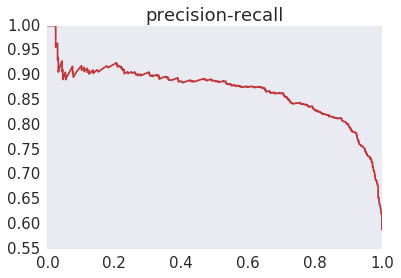

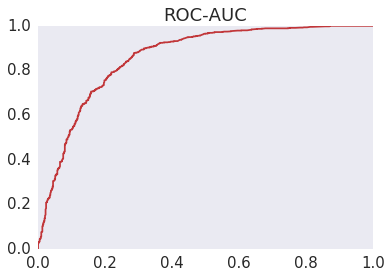

In [46]:
rnd_forest=RandomForestClassifier(n_jobs=-1,n_estimators=100,max_depth=9,max_features=int(math.sqrt(len(train_X.columns))),random_state=17)
rnd_forest.fit(train_X2,train_y)
pred_forest=rnd_forest.predict(test_X2)
print accuracy_score(test_y,pred_forest)
print roc_auc_score(test_y, pred_forest)
getROC_AUC(rnd_forest,test_X2,test_y)

## Новые признаки

In [51]:
train_X3=train_X.copy()
train_X3['sum_cnt_doc']=train_X['fssdccount']+train_X['pfrdcCount']+train_X['fnsdcCount']+train_X['documentsCount']
test_X3=test_X.copy()
test_X3['sum_cnt_doc']=test_X['fssdccount']+test_X['pfrdcCount']+test_X['fnsdcCount']+test_X['documentsCount']

Fitting 5 folds for each of 10 candidates, totalling 50 fits
({'lr__C': 1.0}, 0.75090490292859491)
0.767763157895
0.751332990258


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


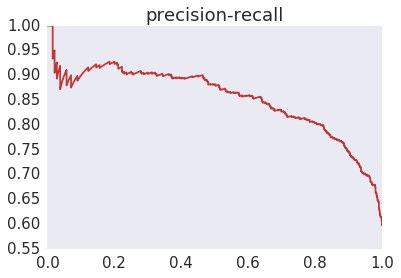

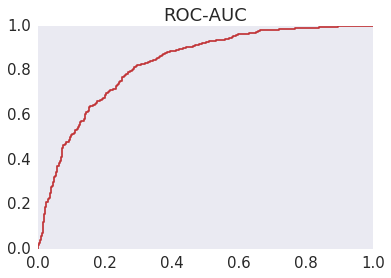

In [52]:
lr=LogisticRegression(n_jobs=-1)
lr_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(n_jobs=-1))])
lr_params = {'lr__C':np.logspace(-8, 1, 10)}
lr_grid = GridSearchCV(lr_pipe, lr_params,
                         cv=5, n_jobs=-1,
                        verbose=True)
lr_grid.fit(train_X3, train_y)
lr_pred=lr_grid.predict(test_X3)
print (lr_grid.best_params_, lr_grid.best_score_)
print accuracy_score(test_y, lr_pred)
print roc_auc_score(test_y, lr_pred)
getROC_AUC(lr_grid,test_X3,test_y)